## Supervised Learning: SVM, Decision Tree & AdaBoost - Finding Donors for CharityML

In this project, the performance of the above supervised algorithms are tested to accurately model an individuals' income using the data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Our goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. 
This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual's general income bracket directly from public sources, we can infer this value from other publically available features.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article "Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid". You can find the article by Ron Kohavi online. The data we investigate here consists of small changes to the original dataset, such as removing the 'fnlwgt' feature and records with missing or ill-formatted entries.

The last column from the dataset, 'income', will be our target label. All other columns are features about each individual in the census database.

In [1]:
import numpy as np
import pandas as pd
from time import time

import visuals as vs
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from __future__ import division
import warnings                  
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("Census.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null int64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null int64
capital-loss       45222 non-null int64
hours-per-week     45222 non-null int64
native-country     45222 non-null object
income             45222 non-null object
dtypes: int64(5), object(9)
memory usage: 4.8+ MB


## Basic Exploration and Visualization of Data

In [3]:
data.head(5)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
n_records = len(data)
n_greater_50k = len(data[data['income'] == '>50K'])
n_at_most_50k = len(data[data['income'] == '<=50K'])
greater_percent = 100 * n_greater_50k / n_records

# Print results
print ("Total number of records: {}".format(n_records))
print ("Individuals making more than $50,000: {}".format(n_greater_50k))
print ("Individuals making at most $50,000: {}".format(n_at_most_50k))
print ("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


Let's visualize the relationship between different features of an individual, and their incomes - breakdown of the counts of people earning above or below 50K based on their sex and education levels.

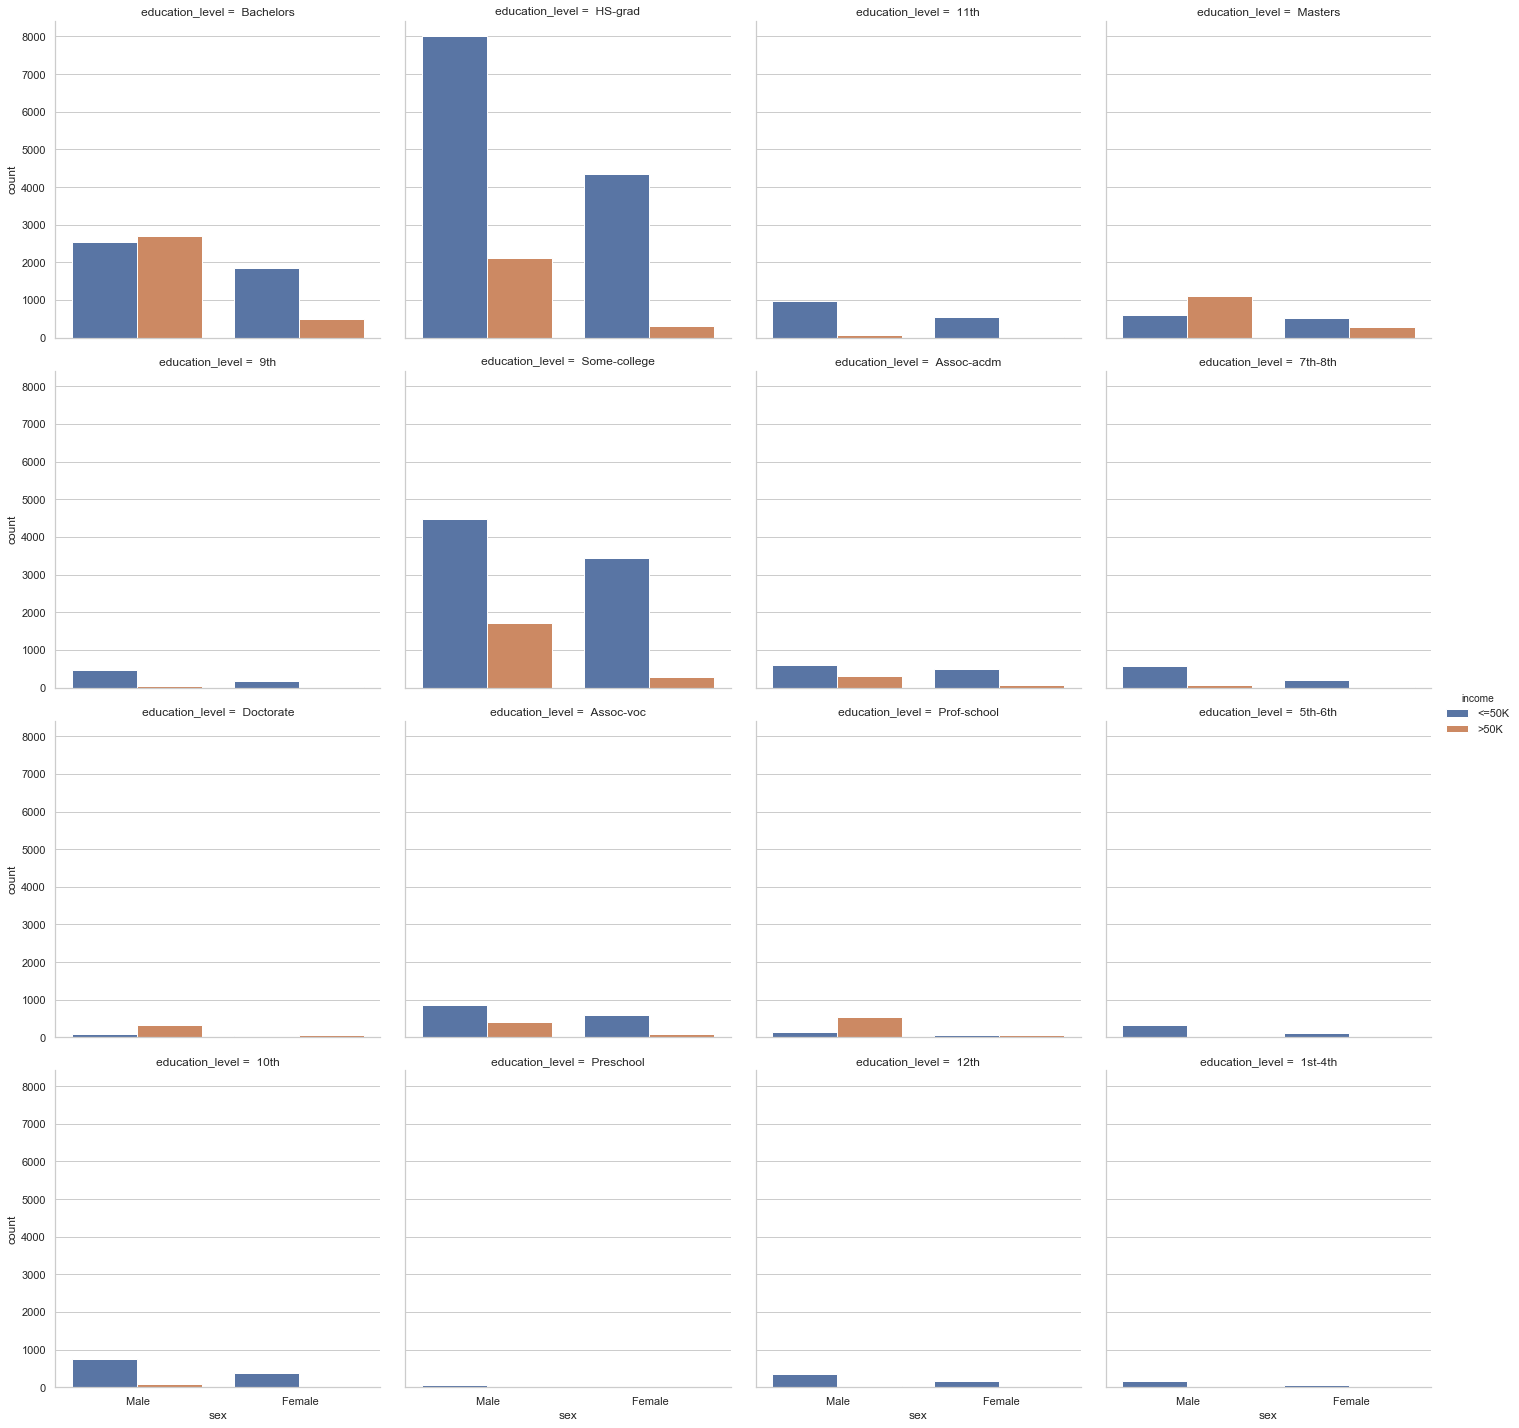

In [5]:
import warnings                  
warnings.filterwarnings("ignore")

sns.set(style="whitegrid", color_codes=True)
sns.factorplot("sex", col='education_level', data=data, hue='income', kind="count", col_wrap=4);


## Preprocess the Data

Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as preprocessing. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

**Transforming Skewed Continuous Features**
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: 'capital-gain' and 'capital-loss'.

Let's plot a histogram of these two features and see how they are distributed.

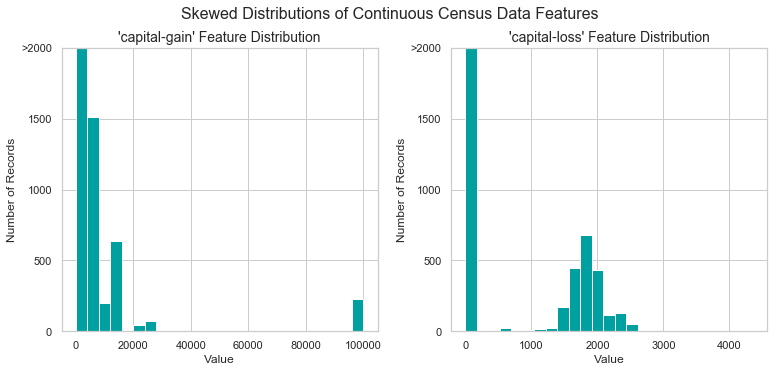

In [6]:
# Visualize skewed continuous features of original data
vs.distribution(data)

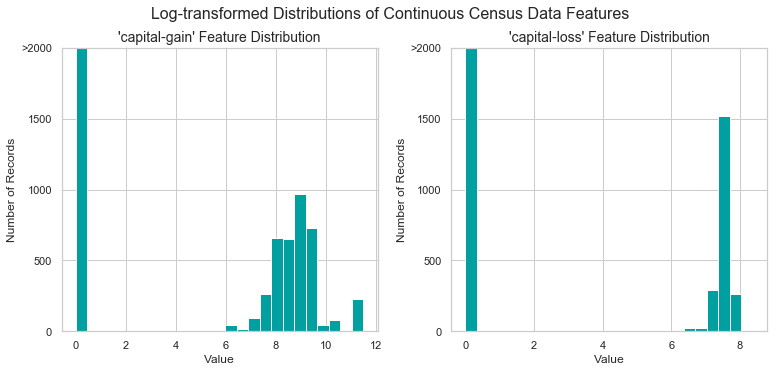

In [7]:
skewed = ['capital-gain', 'capital-loss']
income_raw = data['income']
features_raw = data.drop('income', axis = 1)
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

**Normalizing Numerical Features**

In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as 'capital-gain' or 'capital-loss' above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

features_raw.head(5)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.00000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.00000,0.0,0.397959,Cuba


Moreover, in the data pre-processing stage it is customary to change non-numeric features (categorical variables) such as 'relationship' or 'race' as learning algorithms expect input to be numeric. One approach to accomplish this is using one-hot encoding scheme.
Additionally, as with the non-numeric features, the target label for the feature, 'income' should also be changed to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as 0 and 1, respectively.

In [9]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)
income = income_raw.apply(lambda x: 1 if x == '>50K' else 0)

encoded = list(features.columns)
en_raw = list(features_raw.columns)
print ("{} total features after one-hot encoding.".format(len(encoded)), "It was {} features before one-hot encoding.".format(len(en_raw)))


103 total features after one-hot encoding. It was 13 features before one-hot encoding.


Now all categorical variables have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [10]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


## Evaluating Model Performance
In this section, four different algorithms will be investigated and we will determine which algorithm is the best at modeling the data.

- **Metrics and the Naive Predictor**

CharityML, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using accuracy as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that does not make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is more important than the model's ability to recall those individuals. We can use F-beta score as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$
In particular, when $\beta = 0.5$, more emphasis is placed on precision.

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect accuracy, since we could simply say "this person does not make more than \$50,000" and generally be right, without ever looking at the data! Making such a statement would be called naive, since we have not considered any information to substantiate the claim. It is always important to consider the naive prediction for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, CharityML would identify no one as donors.

### Naive Predictor Performace
What if we chose a model that always predicted an individual who made more than \$50,000, what would that model's accuracy and F-score be on this dataset?

In [11]:
# Calculate accuracy
accuracy = n_greater_50k / n_records

# Calculating precision
precision = n_greater_50k / (n_greater_50k + n_at_most_50k)

#Calculating recall
recall = n_greater_50k / (n_greater_50k + 0)

#Calculate F-score using the formula above for beta = 0.5
fscore =  (1  + (0.5*0.5)) * ( precision * recall / (( 0.5*0.5 * (precision))+ recall))

# Print the results 
print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


## Supervised Learning Models

#### Model Application
Now we'll pick three supervised learning models above that are appropriate for this problem, and test them on the census data.

#### Decision Trees

Real world application: Decision Trees and, in general, CART (Classification and Regression Trees) are often used in financial analysis. A concrete example of it is: for predicting which stocks to buy based on past peformance.
Strengths:
- Able to handle categorical and numerical data.
- Doesn't require much data pre-processing, and can handle data which hasn't been normalized, or encoded for Machine Learning Suitability.
- Simple to understand and interpret.
Weaknesses:
- Complex Decision Trees do not generalize well to the data and can result in overfitting.
- Unstable, as small variations in the data can result in a different decision tree. Hence they are usually used in an ensemble (like Random Forests) to build robustness.
- Can create biased trees if some classes dominate.
- **Candidacy:** Since a decision tree can handle both numerical and categorical data, it's a good candidate for our case (although, the pre-processing steps might already mitigate whatever advantage we would have had). It's also easy to interpret, so we will know what happens under the hood to interpret the results.

#### Support Vector Machines (SVM)

Real world application: Example of a real world use of SVMs include image classification and image segmentation. For example: Face detection in an image. Reference
Strenghs:
- Effective in high dimensional spaces, or when there are a lot of features.
- Kernel functions can be used to adapt to different cases, and can be completely customized if needed. Thus SVMs are versatile.
Weaknesses:
- Doesn't perform well with large datasets.
- Doesn't directly provide probability estimates.
- **Candidacy:** SVMs were chosen because of their effectiveness given high dimensionality. After incorporating dummy variables, we have more than 100 features in our dataset, so SVMs should be a classifier that works regardless of that. Also, our dataset is not that large to be a deterrent.

#### Ensemble methods: AdaBoost

Real world application: Ensemble methods are used extensively in Kaggle competitions, usually in image detection. A real world example of Adaboost is object detection in image, ex: identifying players during a game of basketball. Reference
Strength:
- Ensemble methods, including Adaboost are more robust than single estimators, have improved generalizability.
- Simple models can be combined to build a complex model, which is computationally fast.
Weaknesses:
- If we have a biased underlying classifier, it will lead to a biased boosted model.
- **Candidacy:** Ensemble methods are considered to be high quality classifiers, and adaboost is the one of most popular boosting algorithms. We also have a class imbalance in our dataset, which boosting might be robust to.

### Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model we've chosen, it's important that we create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.

In [12]:
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time()
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time()    
    results['train_time'] = end - start
    
    #Get the predictions on the test set,then get predictions on the first 300 training samples    
    start = time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time()
    
    #Measure Robustness of Model
    results['pred_time'] = end - start
    #Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train) 
        
    #Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    #Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,0.5)
        
    #Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,0.5)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

#### Model Evaluation
Let's train and test the models on training sets of different sizes to see how it affects their runtime and predictive performance (both on the test, and training sets).

DecisionTreeClassifier trained on 362 samples.
DecisionTreeClassifier trained on 3618 samples.
DecisionTreeClassifier trained on 36177 samples.
SVC trained on 362 samples.
SVC trained on 3618 samples.
SVC trained on 36177 samples.
AdaBoostClassifier trained on 362 samples.
AdaBoostClassifier trained on 3618 samples.
AdaBoostClassifier trained on 36177 samples.


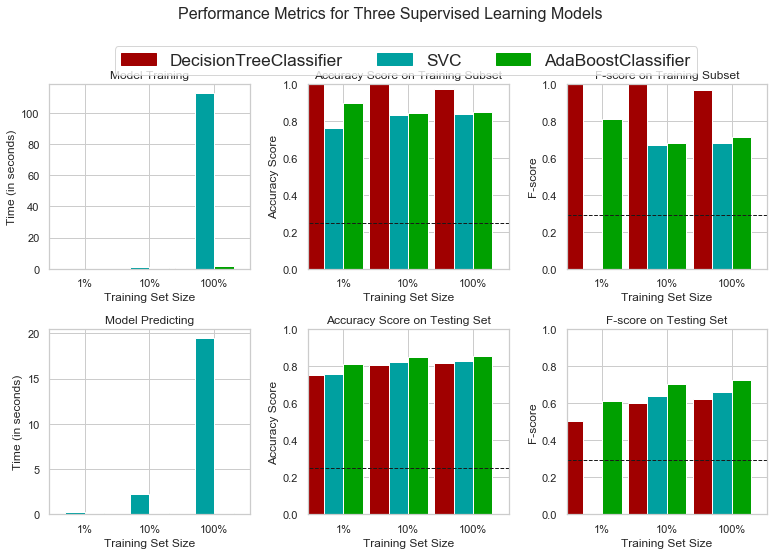

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

#Initialize the three models, the random states are set to 101 so we know how to reproduce the model later
clf_A = DecisionTreeClassifier(random_state=101)
clf_B = SVC(random_state = 101)
clf_C = AdaBoostClassifier(random_state = 101)

#Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(round(len(X_train) / 100))
samples_10 = int(round(len(X_train) / 10))
samples_100 = len(X_train)

#Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [17]:
#Printing out the values
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

DecisionTreeClassifier


,1%,10%,100%
acc_test,0.754008,0.805970,0.817358
acc_train,1.000000,0.996667,0.970000
f_test,0.505562,0.602458,0.625404
f_train,1.000000,0.997191,0.963855
pred_time,0.008928,0.008929,0.009920
train_time,0.002479,0.028273,0.447886


SVC


,1%,10%,100%
acc_test,0.756219,0.822443,0.830072
acc_train,0.760000,0.833333,0.836667
f_test,0.000000,0.640209,0.659238
f_train,0.000000,0.669643,0.677966
pred_time,0.248539,2.216623,19.482941
train_time,0.011904,1.017241,112.925701


AdaBoostClassifier


,1%,10%,100%
acc_test,0.810392,0.849862,0.857601
acc_train,0.896667,0.840000,0.850000
f_test,0.610473,0.701882,0.724551
f_train,0.811688,0.680147,0.711538
pred_time,0.088282,0.088780,0.090272
train_time,0.064982,0.217252,1.898647


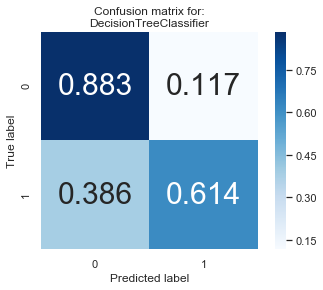

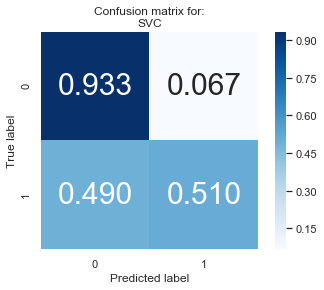

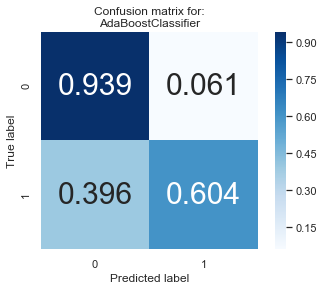

In [18]:
#Visualizing the confusion matrix for each classifier
from sklearn.metrics import confusion_matrix
for i,model in enumerate([clf_A,clf_B,clf_C]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

Looking at the results above, out of the three models, AdaBoost is the most appropriate for our task.

First and foremost, it is the classifier that performs the best on the testing data, in terms of both the accuracy and f-score. It also takes resonably low time to train on the full dataset, which is just a fraction of the 120 seconds taken by SVM, the next best classifier to train on the full training set. So it should scale well even if we have more data.

By default, Adaboost uses a decision stump i.e. a decision tree of depth 1 as its base classifier, which can handle categorical and numerical data. Weak learners are relatively faster to train, so the dataset size is not a problem for the algorithm.

#### But how does Adaboost work?
Adaboost works by combining several simple learners (for ex: decision trees), to create an ensemble of learners that can predict whether an individual earns above 50k or not.

Each of the learners, in our case decision trees, are created using "features" we have about individuals (eg. age, occupation, education, etc) create a set of rules that can predict a person's income.

During the training process, which lasts for several rounds, the Adaboost algorithm looks at instances where it has predicted badly, and prioritizes the correct prediction of those instances in the next round of raining.

With each round, the model finds the best learner (or decision tree) to incorporate into the ensemble, repeating the process for the specified number of rounds, or till we can't improve the predictions further.

All the learners are then combined to make a final ensembled model, where they each vote to predict if a person earns more than 50k or not. Usually we take the majority of the votes to make a final prediction.

Using this model with the census information of individuals, we can predict the same information for a potential new donor and predict if they earn more than 50K or not, and thus make a decision on the likeliness of them donating to charity.

### Improving our Model: Model Tuning
Using grid search (GridSearchCV) with different parameter/value combinations, we can tune our model for even better results.

For Adaboost, we'll tune the n_estimators and learning rate parameters, and also the base classifier paramters (remember our base classifier for the Adaboost ensemble is a Decision tree!).

In [20]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

#Create the parameters list you wish to tune
parameters = {'n_estimators':[50, 120], 
              'learning_rate':[0.1, 0.5, 1.],
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),
              'base_estimator__max_depth' : np.arange(1, 4, 1)
             }

#Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=0.5)

#Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters,scorer)

#Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train)

#Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print (best_clf)

Unoptimized model
------
Accuracy score on testing data: 0.8322
F-score on testing data: 0.6584

Optimized Model
------
Final accuracy score on the testing data: 0.8702
Final F-score on the testing data: 0.7526
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=50, random_state=None)


### Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

#### Feature Relevance Observation
We know that there are thirteen available features for each individual in the census data. Of these thirteen records, it can be guessed which five features might be most the important for prediction.

#### Educated Guess

- Occupation: Different jobs have different payscales. Some jobs pay higher than others.
- Education: People who have completed a higher level of education are better equipped to handle more technical/specialized jobs that pay well.
- Gender: In 1994, I would imagine men generally made much more than women. (As demonstrated in the 1st plot above)
- workclass: The working class they belong to can also be correlated with how much money they make.
- hours-per-week: If you work more hours per week, you're likely to earn more.

Now let's see how our algorithm ranks the features to their importance.

### Extracting Feature Importance

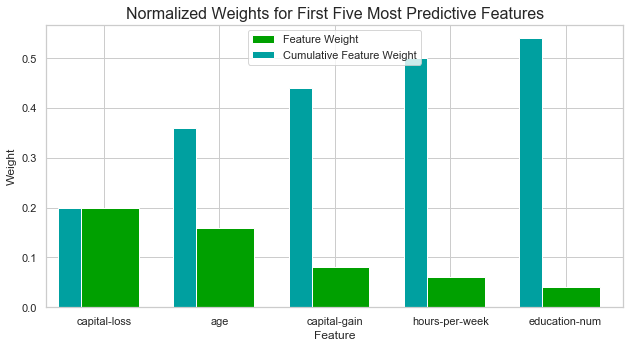

In [40]:
#Train the supervised model on the training set 
model = AdaBoostClassifier().fit(X_train,y_train)
importances = model.feature_importances_
vs.feature_plot(importances, X_train, y_train)

Of the five features predicted in the earlier section, 3 of them, Age, hours per week, education-num (which is a numerical label for education) are included in the list of features considered most important by Adaboost, although with different rankings.

#### Feature Selection
An interesting question here is, how does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of all features present in the data. This hints that we can attempt to reduce the feature space and simplify the information required for the model to learn.

Let's see how a model that is trained only on the selected features, performs.

In [46]:
# Import functionality for cloning a model
from sklearn.base import clone
# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]
# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print ("Final Model trained on full data\n------")
print ("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print ("\nFinal Model trained on reduced data\n------")
print ("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8702
F-score on testing data: 0.7526

Final Model trained on reduced data
------
Accuracy on testing data: 0.8437
F-score on testing data: 0.7065


## Effects of Feature Selection
On a reduced dataset, the final model's accuracy and f-score are still very comparable to the results on the full dataset.

The acccuracy is ~2.7% lower, while the f-score is ~5% lower. Even though Adaboost is relatively faster than one of the other classifiers that we tried out, I'd still consider training on the reduced data (acc. to features) if training time was a factor, and we have more training points to process. This decision will also depend on how important accuracy and f-scores are (or if f-score is more important than the accuracy, as the dip for that is larger than the dip in accuracy), to make a final decision regarding this.